In [1]:
import rasterio
from rasterstats import zonal_stats
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterstats
import pandas as pd
import glob
from tqdm import tqdm
import rasterio.mask
from dotenv import load_dotenv
import os
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

# Set the path to the raster files
load_dotenv()
file_path = os.getenv("raster_path")

Crop Data for Ontario

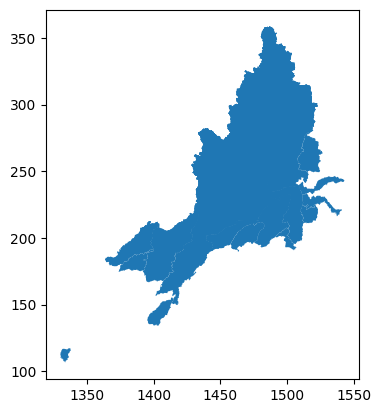

In [10]:
zone_path = os.path.join(file_path, "LEB_description", "sub-basin _ArcGIS","LEB_ONsubbasins_30Sept2021.shp")
zones = gpd.read_file(zone_path)
zones.plot()
plt.show()

In [11]:
print(zones.crs)

# change the crs:
shapefile = zones.to_crs(
    'PROJCS["Albers_Conic_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",44.75],PARAMETER["standard_parallel_2",55.75],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

PROJCS["Lambert_Conformal_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",42.5],PARAMETER["central_meridian",-100],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["kilometer",1000],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


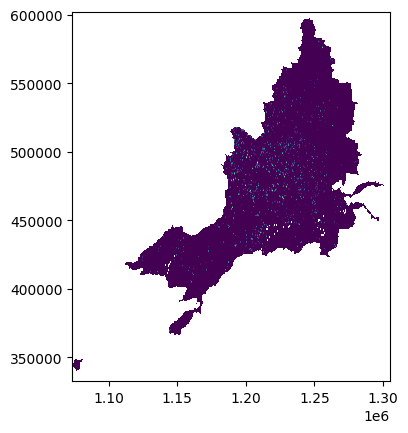

<Axes: >

In [13]:
rf_path = os.path.join(
    file_path, "raw_data", "crops_data", "ON_crop_data", "2011", "on_beans2011.tif"
)
# read the crop raster
rf = rasterio.open(rf_path, mode='r')
show(rf)

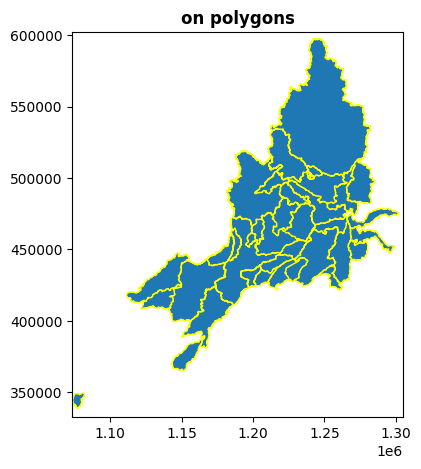

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
show(rf, ax=ax, title="on polygons")
shapefile.plot(ax=ax, facecolor=None, edgecolor="yellow")

plt.show()

Batch Processing for Ontario Crop Data

In [20]:
# ontario shapefile:
ca_zone_path = os.path.join(file_path, "LEB_description", "sub-basin _ArcGIS", "LEB_ONsubbasins_30Sept2021.shp")
on_polygons = gpd.read_file(ca_zone_path)

# the counts to be use while computing the percentage
count_reference = pd.read_csv(os.path.join(file_path, "raw_data", "crops_data", "ON_counts.csv"))
count_reference["ncells"]
StationNames = list(count_reference["station"])

# change crs to match the crs of the crop maps:
shapefile = on_polygons.to_crs('PROJCS["Albers_Conic_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",44.75],PARAMETER["standard_parallel_2",55.75],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

# the main folder
directory = os.path.join(file_path, "raw_data", "crops_data", "ON_crop_data/*")

listofdirectories = glob.glob(directory)
listofdirectories.sort()

for folder in tqdm(listofdirectories):
    listofcropmaps = glob.glob(folder + "/*.tif")
    listofcropmaps.sort()

    # list of all crops dictionary:
    singlecropdict = {}

    for raster in tqdm(listofcropmaps):
        rastefile = rasterio.open(raster, mode="r")
        affine = rastefile.transform
        crop_array = rastefile.read(1)

        # calculating zonal statistics:
        sum_rf = rasterstats.zonal_stats(
            shapefile,
            crop_array,
            affine=affine,
            stats=["count"],
            geojson_out=True,
            nodata=0,
        )

        # extracting cropmaps sums data from the list:
        sum_cropmap = []
        i = 0

        while i < len(sum_rf):
            sum_cropmap.append(sum_rf[i]["properties"])
            i = i + 1

        # transforming information into a dataframe:
        sorted_data = sorted(sum_cropmap, key=lambda x: x["Station"])
        df_sum_cropmap = pd.DataFrame(sorted_data)

        # collecting all the sums into one big list
        cropName = raster.split("/")[-1].split(".")[0]
        cropsumvalues = list(df_sum_cropmap["count"])
        singlecrop = {cropName: cropsumvalues}

        singlecropdict.update(singlecrop)

        # calculate the percentage count of each crop:
        df_singlecrop = pd.DataFrame(singlecropdict)

        df_singlecrop.insert(0, "ncells", count_reference["ncells"])

        new_df_singlecrop = df_singlecrop.set_index("ncells")

        percent_singlecrop = new_df_singlecrop.apply(
            lambda x: x * (100 / new_df_singlecrop.index)
        )

        percent_singlecrop.insert(0, "station", StationNames)

        # saving to csv :
        # pathout =
        # percent_singlecrop.to_csv(
        #     pathout + "on_" + folder.split("/")[-1] + ".csv", index=True
        # )

100%|██████████| 10/10 [02:18<00:00, 13.82s/it]


Crop Data for LEB portion from the USA

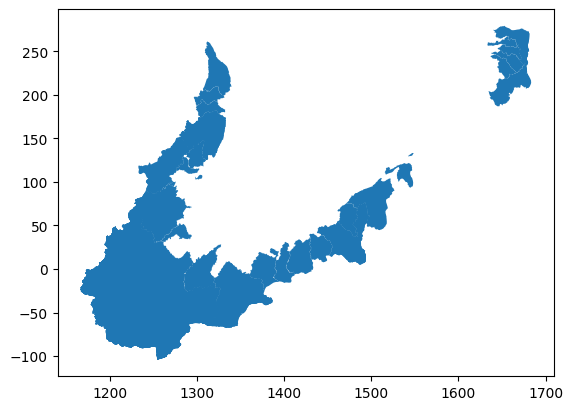

In [23]:
# LEB_USAsubbasins_30Sept2021.shp
us_zone_path = os.path.join(
    file_path, "LEB_description", "sub-basin _ArcGIS", "LEB_USAsubbasins_30Sept2021.shp"
)
us_zones = gpd.read_file(us_zone_path)
us_zones.plot()
plt.show()

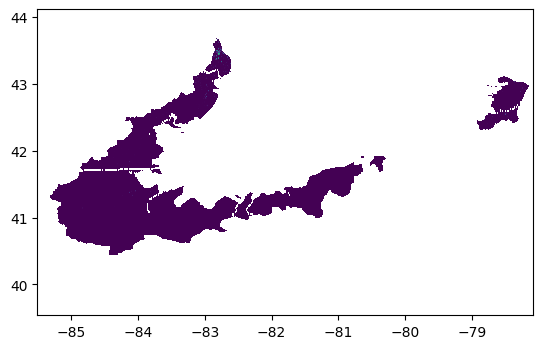

<Axes: >

In [24]:
us_rf_path = os.path.join(
    file_path, "raw_data", "crops_data", "US_crop_data", "2011", "us_beans2011.tif"
)
# read the crop raster
us_rf = rasterio.open(us_rf_path, mode="r")
show(us_rf)

In [ ]:
# us shapefile:
us_polygons = gpd.read_file(us_zone_path)

# the counts to be use while computing the percentage
us_count_reference = pd.read_csv(os.path.join(file_path, "raw_data", "crops_data", "US_counts.csv"))

us_count_reference["ncells"]
StationNames = list(us_count_reference["station"])

# the main folder
directory = os.path.join(file_path, "raw_data", "crops_data", "US_crop_data/*")

listofdirectories = glob.glob(directory)
listofdirectories.sort()

for folder in tqdm(listofdirectories):
    listofcropmaps = glob.glob(folder + "/*.tif")
    listofcropmaps.sort()

    # list of all crops dictionary:
    singlecropdict = {}

    for raster in tqdm(listofcropmaps):
        rasterfile = rasterio.open(raster, mode="r")
        cropmap_array = rasterfile.read(1)
        affine = rasterfile.transform

        # First the shapefile:
        default_crs = "EPSG:5070"
        if us_polygons.crs is None:
            us_polygons = us_polygons.set_crs(default_crs)

        us_polygons = us_polygons.to_crs(rasterfile.crs)

        sum_rf = zonal_stats(
            us_polygons,
            cropmap_array,
            affine=affine,
            stats=["count", "sum"],
            geojson_out=True,
            nodata=0,
        )

        # extracting cropmaps sums data from the list:
        sum_cropmap = []
        i = 0

        while i < len(sum_rf):
            sum_cropmap.append(sum_rf[i]["properties"])
            i = i + 1

        # transforming information into a dataframe:
        sorted_data = sorted(sum_cropmap, key=lambda x: x["GAGE_ID"])
        df_sum_cropmap = pd.DataFrame(sorted_data)

        # collecting all the sums into one big list
        cropName = raster.split("/")[-1].split(".")[0]
        cropsumvalues = list(df_sum_cropmap["count"])
        singlecrop = {cropName: cropsumvalues}

        singlecropdict.update(singlecrop)

        # calculate the percentage count of each crop:
        df_singlecrop = pd.DataFrame(singlecropdict)

        df_singlecrop.insert(0, "ncells", us_count_reference["ncells"])

        new_df_singlecrop = df_singlecrop.set_index("ncells")

        percent_singlecrop = new_df_singlecrop.apply(
            lambda x: x * (100 / new_df_singlecrop.index)
        )

        percent_singlecrop.insert(0, "station", StationNames)
        # saving to csv :
        # pathout =

        # percent_singlecrop.to_csv(
        #     pathout + "us_" + folder.split("/")[-1] + ".csv", index=True
        # )